The count for frequency is:  725

The count for power is:  725

The percent error is:  10.450086572535554

Minimum of the Periodogram:  3.963931384887479e-09
Maximum of the Periodogram:  0.0789736914920724
Index =  (array([10]),) [10]
Frequency at Maximum Power [8.32425591e-08]
Period = [139.04034429] days
# of data points = 145 Start MJD = 53140.768414 End MJD = 53432.75313700001
Data Span = 291.98472300000765 days
Mean Spacing = 2.027671687500053 days
Mean power = 0.014076049196119132 Power standard deviation = 0.015202100882139056
Number of independent frequencies [HB86] = 1373.6455
Nyquist-limited frequencies = 72.5
Z= 4.268991687339839 False Alarm Probability = 0.9999999960957331
AltFAP (Nyquist) = 0.6400786289812785


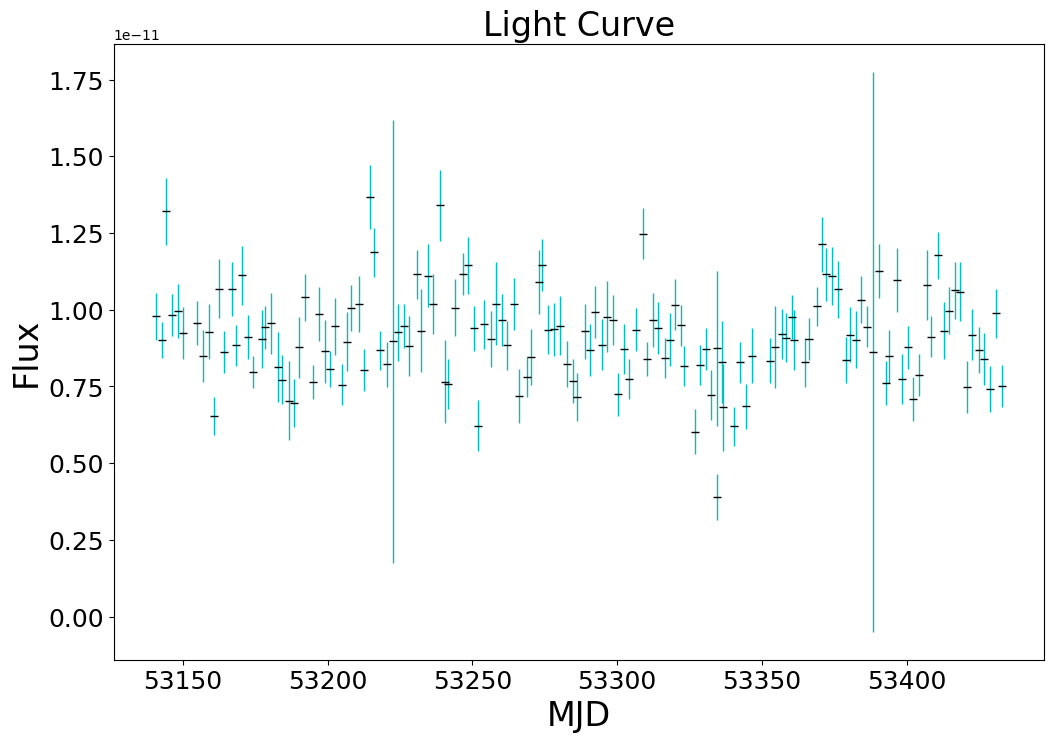

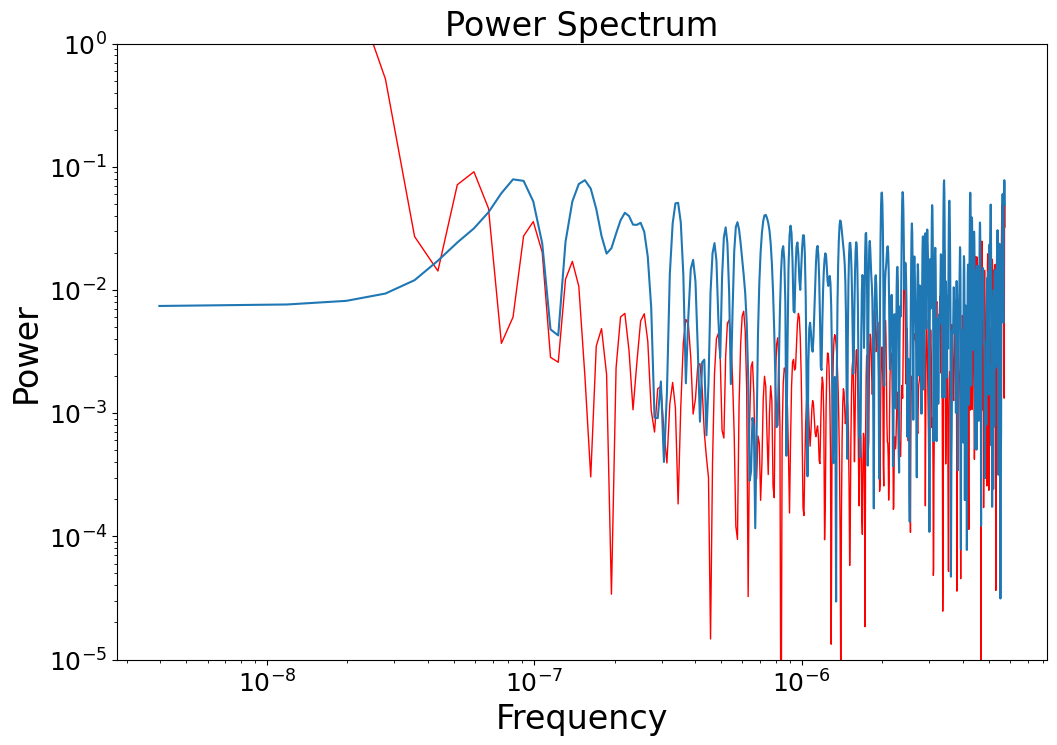

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import LombScargle

#file name (including .type) that contains the flux data
filename = "F0210_PG0052+251.txt" # @param {type:"string"}
#number of lines to skip at the beginning of the file
skip_header = 17 # @param {type:"integer"}
#number of lines to skip at bottom
skip_footer = 0 # @param {type:"integer"}


#This loads the text files saved from the UCSD wesbite
#skip_header is the number of lines to skip at the beginning of the file
#AGN = np.genfromtxt('filename.txt', skip_header = 0, skip_footer = 0)
AGN = np.genfromtxt(filename, skip_header = skip_header, skip_footer = skip_footer)

#This sets up the values
x = 86400*AGN[:,0]  #This is the first column of the data set (MJD midpoint of observation)
y = AGN[:,1] #Second column of the data set (Flux)
dy = AGN[:,2] #Third column of the data set (the uncertainty)

#Put Thomas test on same graph
yy = 0 * x + 1 #Need to set the y values to one, in order to have the y axis be zero
dyy = 0 * x + 42
ffrequency, ppower = LombScargle(x, yy, dyy).autopower(nyquist_factor = 2)
#Gets timespan and spacing of data
NumData = len (x)
Span = x[NumData - 1] - x[0]
MeanSpacing = Span / (NumData - 1)

#This sets up the periodogram
frequency, power = LombScargle(x, y, dy).autopower(nyquist_factor = 2)

#This gives the number of points in the periodogram
A = len (frequency)
B = len (power)

#Getting the averages of the error and the flux in order to find the percent error
Error = np.mean(dy)
Mean = np.mean(y)


#The first plot is for the light curve
plt.subplots(1,1,figsize=(12,8))
plt.title('Light Curve', fontsize=24)
plt.xlabel('MJD', fontsize=24)
plt.ylabel('Flux', fontsize=24)
#plt.xlim((52750,52775))
#plt.ylim((2e-12,9e-12))
plt.tick_params(labelsize=18)
#plt.ylim(-.0050,0.015)
#plt.plot(x/86400, y)
plt.errorbar(x/86400,y,yerr=dy,fmt='_k',ecolor='c',elinewidth=1);
#plt.savefig('NGC6251_LC.png')

array = frequency, power

#Finds the maximum and the minimum of the periodogram
np.max(array), np.min(array)
result = np.where(power == np.amax(power))
item = result[0]
fofmax = frequency[item]
period = 1/(fofmax*86400)
#Finds the False Alarm Probability [Horne & Baliunas, 1986]
N_i = -6.392 + 1.193 * B + 0.00098 * B ** 2
Mu = np.mean(power)
Sigma = np.std(power)
Z = (np.max(power) - Mu)/Sigma
FAP = 1 - (1 - np.exp(-Z)) ** N_i
altFAP = 1 - (1 - np.exp(-Z)) ** (NumData/2)

#This plot is for the power spectrum
plt.subplots(1,1,figsize=(12,8))
plt.xscale('log') #This sets the x axis as a logarithmic function
plt.yscale('log') #This sets the y axis as a logarithmic function
plt.title('Power Spectrum', fontsize=24)
plt.xlabel("Frequency", fontsize=24)
plt.ylabel('Power', fontsize=24)
#plt.xlim((1e-7,4e-7))
plt.ylim((1e-5,1))
plt.plot(ffrequency, ppower,'r', linewidth=1)
plt.plot(frequency,power)
plt.tick_params(labelsize=18)
#plt.savefig('NGC6251_LSP.png')


#This prints how many data points there are going to be in the output data file of the periodogram
print ("The count for frequency is: " ,A,)
print ("")
print ("The count for power is: " ,B,)
print ("")
#This will calculate and print out the percent error
print ("The percent error is: ",((Error/Mean)*100),)
#Prints out the maximum and minimum of the periodogram
print ("")
print ("Minimum of the Periodogram: ", np.min(array))
print ("Maximum of the Periodogram: ", np.max(array))
print ("Index = ", result, item)
print ("Frequency at Maximum Power", fofmax)
print ("Period =", period, "days")
print ("# of data points =", NumData, "Start MJD =", x[0]/86400, "End MJD =", x[NumData - 1]/86400)
print ("Data Span =", Span/86400, "days",)
print ("Mean Spacing =", MeanSpacing/86400, "days")
print ("Mean power =", Mu, "Power standard deviation =", Sigma)
print ("Number of independent frequencies [HB86] =", N_i)
print ("Nyquist-limited frequencies =", NumData/2)
print ("Z=", Z, "False Alarm Probability =", FAP)
print ("AltFAP (Nyquist) =", altFAP)